In [294]:
import gym
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from IPython import display

from tqdm import tqdm
import os

# Reinforcement Learning #1

## Create an environment

In [30]:
env = gym.make('CartPole-v1')

# Initialize the environment
obs = env.reset()

Observation object contains the following information:

* cart's horizontal position, where `0.0` is center
* cart's velocity, where positive means right
* pole's angle, where `0.0` means vertical
* pole's angular velocity - positive = clockwise

In [31]:
obs

array([ 0.04178534, -0.03839284, -0.00748959,  0.01395795])

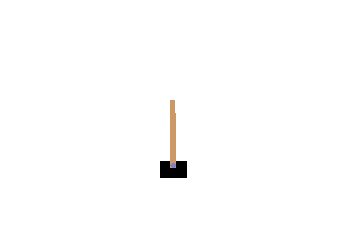

In [32]:
# Visualize the environment
plt.imshow(env.render(mode = 'rgb_array'))
plt.grid(b = None)
plt.axis('off')
plt.show()

# NOTE: To close the external render use env.close() after finishing your experiments

## Define a basic policy

To define our policy let's see what actions can we take:

In [33]:
env.action_space

Discrete(2)

There are two possible actions: accelarating the cart left (`0`) or right (`1`).

Let's create a policy that accelerates the cart left when the pole is leaening towards right and right otherwise.

Before we start, let's see how to take an action.

In [34]:
# Let's accelerate the cart right
action = 1

In [35]:
obs, reward, done, info = env.step(action)

Taking an action results in new cart and pole coordinates. We also get a reward and information if the trial has finished (either 200 iterations passed or the pole fell or the cart left the main screen) and additional info on the environment (optional).

In [42]:
def basic_policy(obs):
    pole_angle = obs[2]
    return 0 if pole_angle < 0 else 1

## Take action!

In [43]:
# Let's pick n_episodes and run the simulation with our basic_policy
N_EPISODES = 500
N_STEPS = 200

total_reward = []

for episode in tqdm(range(N_EPISODES)):
    episode_reward = 0
    obs = env.reset()
    
    for step in range(N_STEPS):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_reward += reward
        
        if done:
            break
        
    total_reward.append(episode_reward)

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1658.18it/s]


Let's see how our basic policy did!

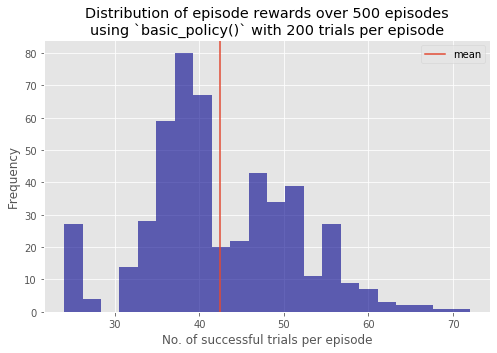

In [65]:
plt.figure(figsize = (8, 5))
plt.hist(total_reward, alpha = .6, color = 'darkblue', bins = int(np.sqrt(N_EPISODES)))
plt.axvline(np.mean(total_reward), label = 'mean')
plt.xlabel('No. of successful trials per episode')
plt.ylabel('Frequency')
plt.legend()
plt.title(f'Distribution of episode rewards over {N_EPISODES} episodes\nusing `basic_policy()` with {N_STEPS} trials per episode')
plt.show()

As we can see, our policy did not work very well. Only in very rare cases our cart was able to continue the game until ~70 trials out of 200. On average, the game was over after around 42 trials 😥

Let's see one of the games using our policy.

Done in 40 steps.


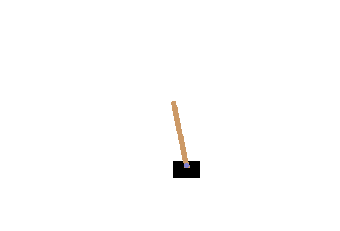

In [78]:
obs = env.reset()

for step in range(N_STEPS):
    
    # Display env and clean it
    plt.imshow(env.render(mode = 'rgb_array'))
    plt.grid(b = None)
    plt.axis('off')
    display.display(plt.gcf())    
    display.clear_output(wait = True)
#     print(step)
    
    # Take action
    action = basic_policy(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward
        
    if done:
        print(f'Done in {step} steps.')
        break

env.close()

## Neural Network Policy

In [283]:
# Define network params
N_INPUTS = 4
N_DENSE = 5   # a small hidden layer for a simple problem

In [284]:
# Define the model
model = keras.models.Sequential([
    keras.layers.Dense(N_DENSE, activation = 'elu', input_shape = [N_INPUTS]),
    keras.layers.Dense(1, activation = 'sigmoid')
])

### Policy Gradients

In [285]:
def play_one_step(env, obs, model, loss_func):

    """
    Play one step using tf.keras model as a policy
    """
    
    with tf.GradientTape() as tape:
        
        proba_left = model(obs[np.newaxis])    # Model expects batch, we add new axis to fulfill this req.
        action = (tf.random.uniform([1, 1]) > proba_left)    
        
        # Let's compute probability of accelerating left
        # If `action` is 0 (meaning "acc. left"), the probability of accelerating left will be 1; 0 otherwise
        target_proba_left = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        
        # Compute loss
        loss = tf.reduce_mean(loss_func(target_proba_left, proba_left))
        
    # Get gradients
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    
    # Note that we're not applying the gradient right away - just return them
    return obs, reward, done, grads

In [286]:
def play_n_episodes(env, n_episodes, n_max_staeps, model, loss_func):
    
    """
    Play n episodes using tf.keras model as a policy
    """
    
    all_rewards = []
    all_grads = []
    
    for episode in range(n_episodes): 
        
        episode_rewards = []
        episode_grads = []
        
        obs = env.reset()
        
        for step in range(n_max_staeps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_func)
            
            episode_rewards.append(reward)
            episode_grads.append(grads)
            
            if done:
                break
                
        all_rewards.append(episode_rewards)
        all_grads.append(episode_grads)
        
    return all_rewards, all_grads

In [287]:
def discount(rewards, discount_factor):
    
    """
    Discount rewards
    """
    
    discounted = np.array(rewards).astype(np.float32)  # Cast to float32 - as new ver of np keeps it as ints
    
    for i in range(len(rewards) - 2, -1, -1):
        discounted[i] += discounted[i + 1] * discount_factor
    
    return discounted

In [288]:
# Check if works as expected - EV = [24.4, 18, 10]
discount([10, 10, 10], .8)

array([24.4, 18. , 10. ], dtype=float32)

In [289]:
def discount_and_normalize(all_rewards, discount_factor):
    
    """
    Applies discount to rewards and and normalizes them.
    """
    
    all_discounted_rewards = [discount(rewards, discount_factor) for rewards in all_rewards]
    
    # Get mean and sd of all rewards
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = np.mean(flat_rewards)
    reward_sd = np.std(flat_rewards)
    
    return [(discounted_rewards - reward_mean) / reward_sd for discounted_rewards in all_discounted_rewards]

In [290]:
# Sanity check - expected -> [-.28..., -.86..., -.1.18...], [1.26..., 1.07...]
discount_and_normalize([[10, 0, -50], [10, 20]], discount_factor = .8)

[array([-0.28435072, -0.86597717, -1.189103  ], dtype=float32),
 array([1.2666533, 1.0727777], dtype=float32)]

### Model params and training loop

In [291]:
N_ITERS = 150
N_EPISODES_PER_UPDATE = 10
N_MAX_STEPS = 200
DISCOUNT_FACTOR = .95

In [292]:
optimizer = keras.optimizers.Adam(lr = 1e-2)
loss_func = keras.losses.binary_crossentropy

In [293]:
# Training loop

env.reset()

for i in tqdm(range(N_ITERS)):
    
    all_rewards, all_grads = play_n_episodes(env, N_EPISODES, N_MAX_STEPS, model, loss_func)
    all_final_rewards = discount_and_normalize(all_rewards, DISCOUNT_FACTOR)
    
    all_mean_grads = []
    
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
                        [final_reward * all_grads[episode_index][step][var_index]
                            for episode_index, final_rewards in enumerate(all_final_rewards)
                                for step, final_reward in enumerate(final_rewards)], axis = 0)
        
        all_mean_grads.append(mean_grads)
        
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

  0%|                                                                                          | 0/150 [00:00<?, ?it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



100%|█████████████████████████████████████████████████████████████████████████████| 150/150 [9:01:17<00:00, 216.52s/it]


In [296]:
# Save model
os.makedirs('./models', exist_ok = True)
model.save('./models/gradient_policy_01/')

INFO:tensorflow:Assets written to: ./models/gradient_policy_01.model/assets


### Check how NN model works

In [305]:
# Let's pick n_episodes and run the simulation with our nn policy
N_EPISODES = 500
N_STEPS = 200

total_reward = []

for episode in tqdm(range(N_EPISODES)):
    episode_reward = 0
    obs = env.reset()
    
    for step in range(N_STEPS):
        action = (tf.random.uniform([1, 1]) > model(obs[np.newaxis]))[0][0].numpy().astype(np.int32)
        obs, reward, done, info = env.step(action)
        episode_reward += reward
        
        if done:
            break
        
    total_reward.append(episode_reward)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:12<00:00,  3.77it/s]


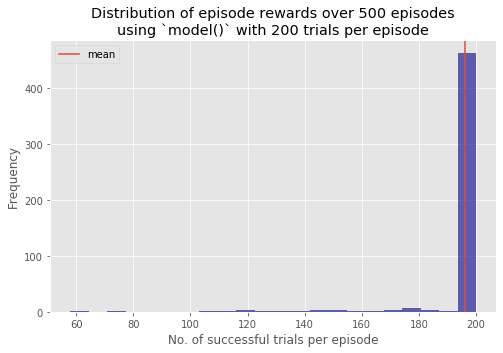

In [307]:
plt.figure(figsize = (8, 5))
plt.hist(total_reward, alpha = .6, color = 'darkblue', bins = int(np.sqrt(N_EPISODES)))
plt.axvline(np.mean(total_reward), label = 'mean')
plt.xlabel('No. of successful trials per episode')
plt.ylabel('Frequency')
plt.legend()
plt.title(f'Distribution of episode rewards over {N_EPISODES} episodes\nusing `model()` with {N_STEPS} trials per episode')
plt.show()

Neural network policy works much better! 

Let's visualize one episode.

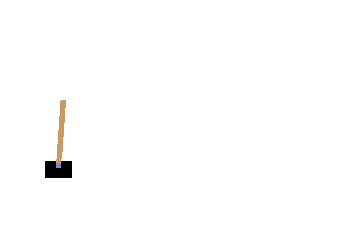

In [308]:
obs = env.reset()

for step in range(N_STEPS):
    
    # Display env and clean it
    plt.imshow(env.render(mode = 'rgb_array'))
    plt.grid(b = None)
    plt.axis('off')
    display.display(plt.gcf())    
    display.clear_output(wait = True)
#     print(step)
    
    # Take action
    action = (tf.random.uniform([1, 1]) > model(obs[np.newaxis]))[0][0].numpy().astype(np.int32)
    obs, reward, done, info = env.step(action)
    episode_reward += reward
        
    if done:
        print(f'Done in {step} steps.')
        break

env.close()